In [2]:
from IPython.display import Video
import cv2
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def imshow(a):
    a = a.clip(0, 255).astype("uint8")
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

In [4]:
Video('chess_1.mp4')

In [5]:
chess = cv2.VideoCapture("./chess_1.mp4")
if chess.isOpened():
    print("Video loaded")

width = int(chess.get(3))
height = int(chess.get(4))

print(height, width)

fps = chess.get(cv2.CAP_PROP_FPS)
print(fps)

Video loaded
832 720
20.0


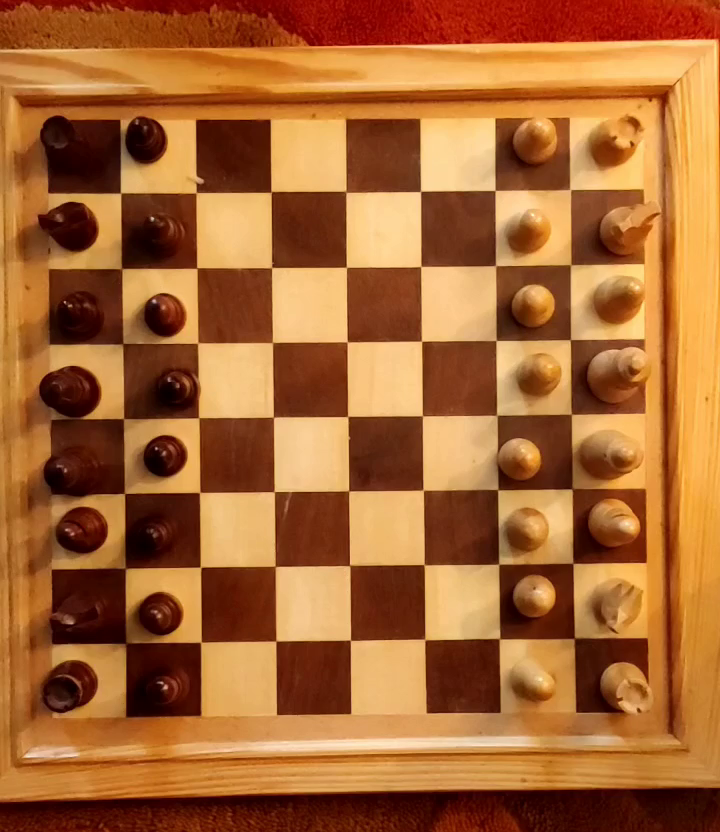

In [6]:
chess.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = chess.read()
imshow(frame)

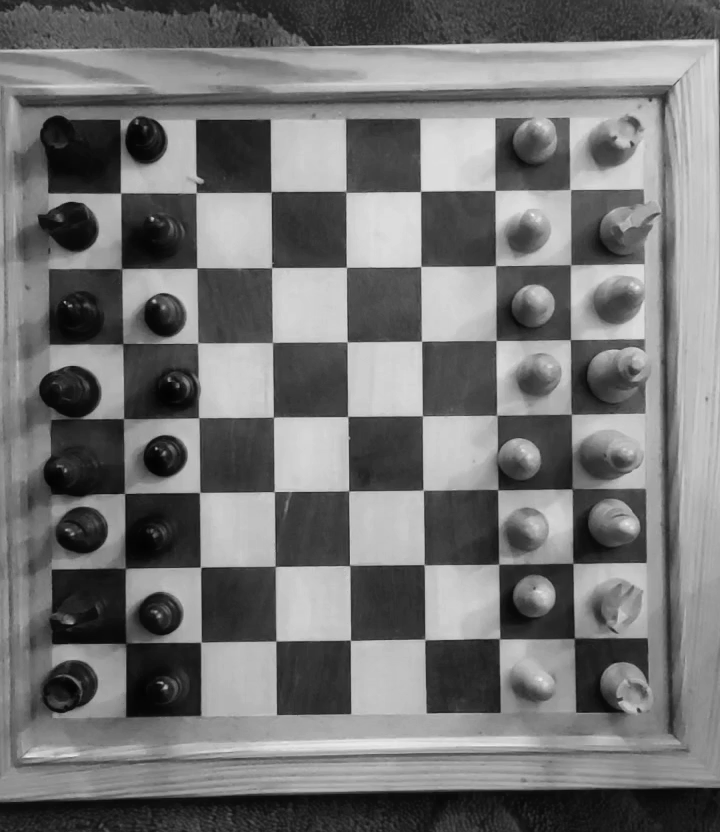

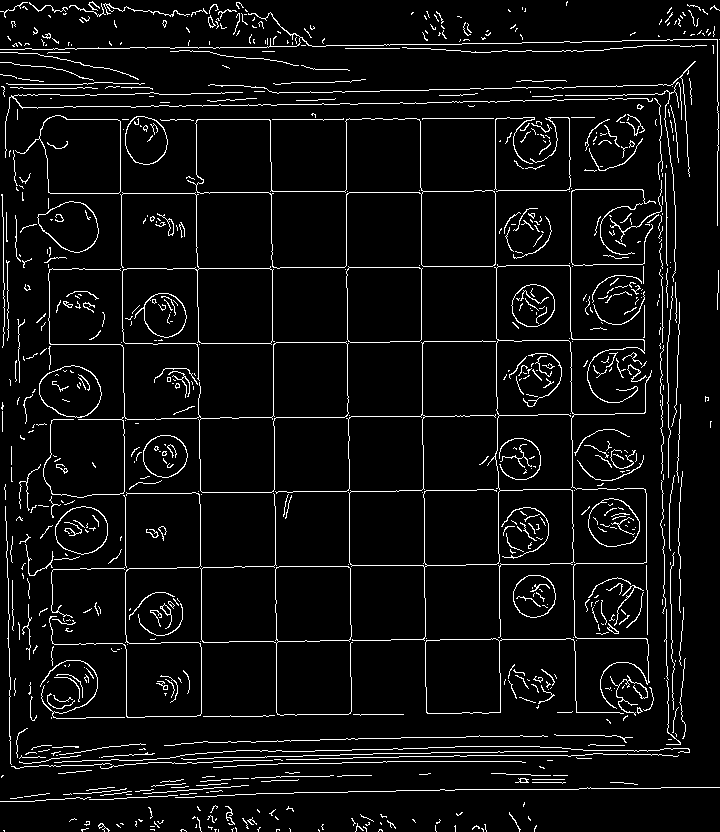

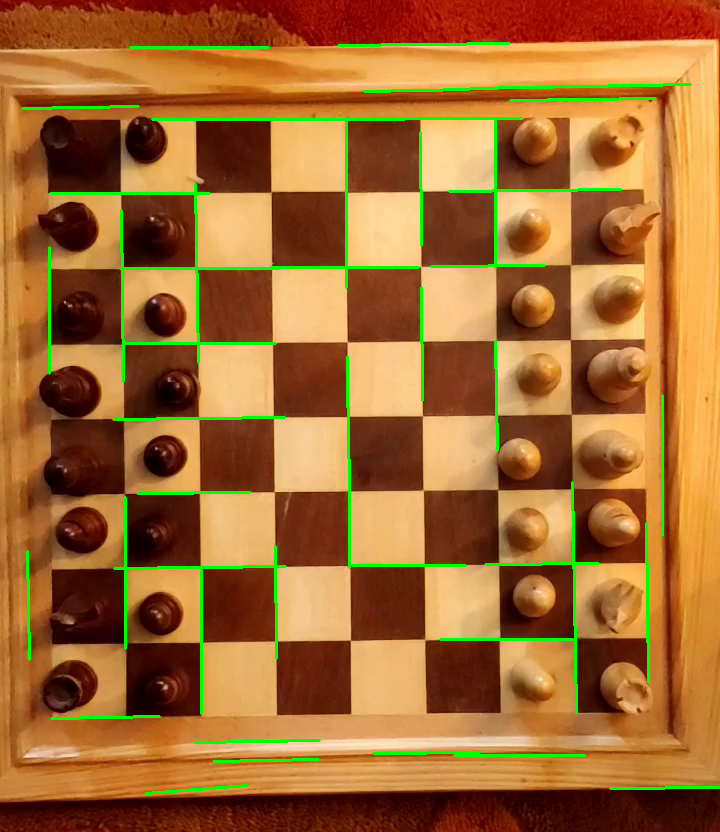

In [7]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
image = frame.copy()
# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform Canny edge detection
edges = cv2.Canny(blurred, 50, 70)  # Adjust thresholds (50 and 150) for different levels of edge detection

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

# Draw detected lines on the image
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw lines on the original image


# Display the original and edge-detected images
imshow(gray)
imshow(edges)
imshow(image)



In [51]:
def cluster_points(points, threshold=10):
    num_points = len(points)
    clustered = np.zeros(num_points, dtype=int) - 1  # Initialize with -1 indicating unassigned points
    cluster_id = 0

    for i in range(num_points):
        if clustered[i] == -1:
            clustered[i] = cluster_id
            while True:
                indices = np.where(clustered == cluster_id)[0]
                new_points = np.any(np.linalg.norm(points[indices][:, None] - points, axis=-1) < threshold, axis=0)
                newly_assigned = np.logical_and(new_points, clustered == -1)
                if not np.any(newly_assigned):
                    break
                clustered[newly_assigned] = cluster_id

            cluster_id += 1

    centroids = []
    for cluster in range(cluster_id):
        indices = np.where(clustered == cluster)[0]
        cluster_points = points[indices]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)

    return np.array(centroids)

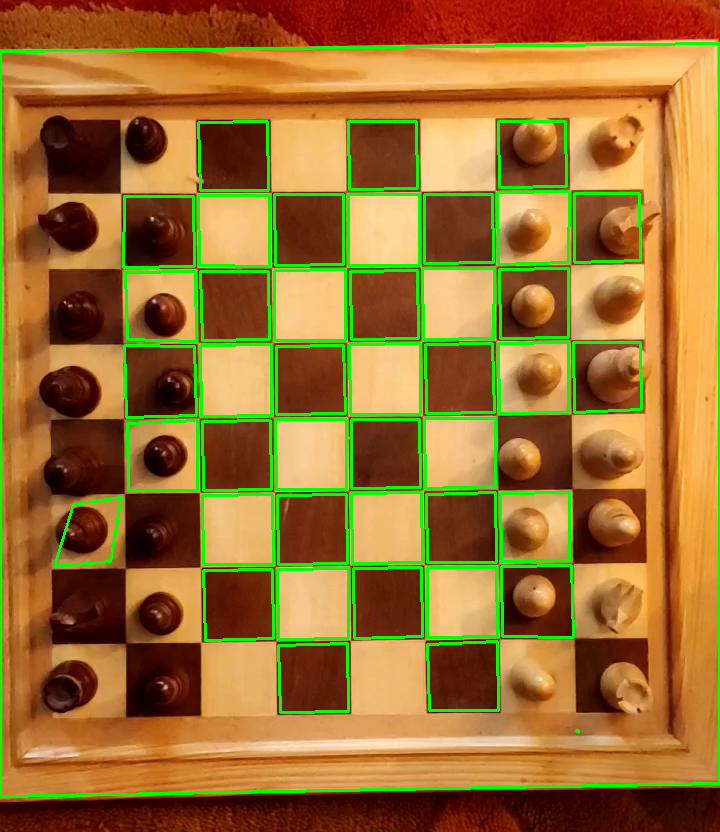

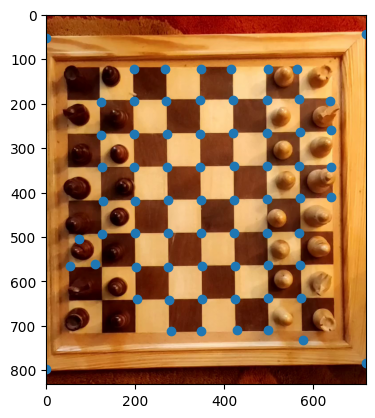

In [75]:
image = frame.copy()
mask = np.zeros(image.shape, dtype=np.uint8)
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Remove noise with morph operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dilated = cv2.dilate(thresh, kernel=np.ones((5,5)))
eroded  = cv2.erode(thresh, kernel=np.ones((5,5)))
invert = 255 - dilated

# Find contours and find squares with contour area filtering + shape approximation
cnts1 = cv2.findContours(invert, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts2 = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts1 = cnts1[0] if len(cnts1) == 2 else cnts1[1]
cnts2 = cnts2[0] if len(cnts2) == 2 else cnts2[1]

vertices_list = list()

for cnts in [cnts1, cnts2]:
    for contour in cnts:
        hull = cv2.convexHull(contour)
        approx = cv2.approxPolyDP(hull, 0.04 * cv2.arcLength(hull, True), True)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h
            vertices = approx.reshape(-1, 2) 
            if 0.95 <= aspect_ratio <= 1.05:
                cv2.drawContours(image, [approx], 0, (0, 255, 0), 2)  # Draw contours around squares
                vertices_list.extend(vertices)


vertices_list = np.array(vertices_list)
vertices_list = cluster_points(vertices_list)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
plt.imshow(frame_rgb)
plt.scatter(vertices_list[:, 0], vertices_list[:, 1])

imshow(image)
plt.show()

In [190]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.cluster import KMeans

def filter_vertices(corner_list, vertices_list, threshold=10):
    filtered_vertices = []

    for vertex in vertices_list:
        distances = np.linalg.norm(corner_list - vertex, axis=1)
        closest_distance = np.min(distances)
        
        if closest_distance <= threshold:
            filtered_vertices.append(vertex)

    return np.array(filtered_vertices)

def find_nearest_transformations(points, num_neighbors=4):
    # Using sklearn's NearestNeighbors for efficient neighbor search
    nbrs = NearestNeighbors(n_neighbors=num_neighbors, algorithm='ball_tree').fit(points)
    _, indices = nbrs.kneighbors(points)
    transformations = []
    for neighbors in indices:
        for i in neighbors[1:]:
            transformation = tuple(np.round(np.abs(points[neighbors[0]] - points[i])))
            transformations.append(transformation)

    counter = Counter(transformations)
    most_common_transformations = counter.most_common(10)
    
    coordinates = np.array([point[0] for point, _ in most_common_transformations])
    frequencies = np.array([freq for _, freq in most_common_transformations])

    normalized_frequencies = frequencies / np.max(frequencies)

    features = np.column_stack((coordinates, normalized_frequencies))

    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(features)

    cluster_1 = [most_common_transformations[i] for i, label in enumerate(labels) if label == 0]
    cluster_2 = [most_common_transformations[i] for i, label in enumerate(labels) if label == 1]

    centroid_1 = np.mean([np.array(point[0]) for point in cluster_1], axis=0)
    centroid_2 = np.mean([np.array(point[0]) for point in cluster_2], axis=0)

    return(centroid_1, centroid_2)

def add_new_vertices(filtered_vertices_list, transformations, x_bound, y_bund):
    extended_vertices_list = list(filtered_vertices_list.copy())

    for vertex in filtered_vertices_list:
        for transformation in transformations:
            for i in [-1, 1]:
                new_vertex = vertex + i * transformation

                #check if new point in image
                if new_vertex[0] > x_bound or new_vertex[0] < 0 or new_vertex[1] > y_bund or new_vertex[1] < 0:
                    continue

                distances = np.linalg.norm(filtered_vertices_list - new_vertex, axis=1)

                min_distance = np.min(distances)

                if min_distance > np.sum(transformation) / 2:
                    extended_vertices_list.append(new_vertex)



    extended_vertices_list = np.array(extended_vertices_list)
    extended_vertices_list = cluster_points(extended_vertices_list, threshold=np.sum(transformation[0]) /2)

    return extended_vertices_list


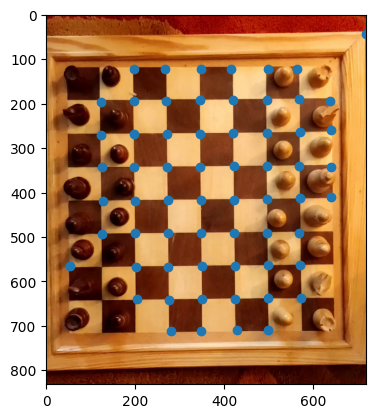

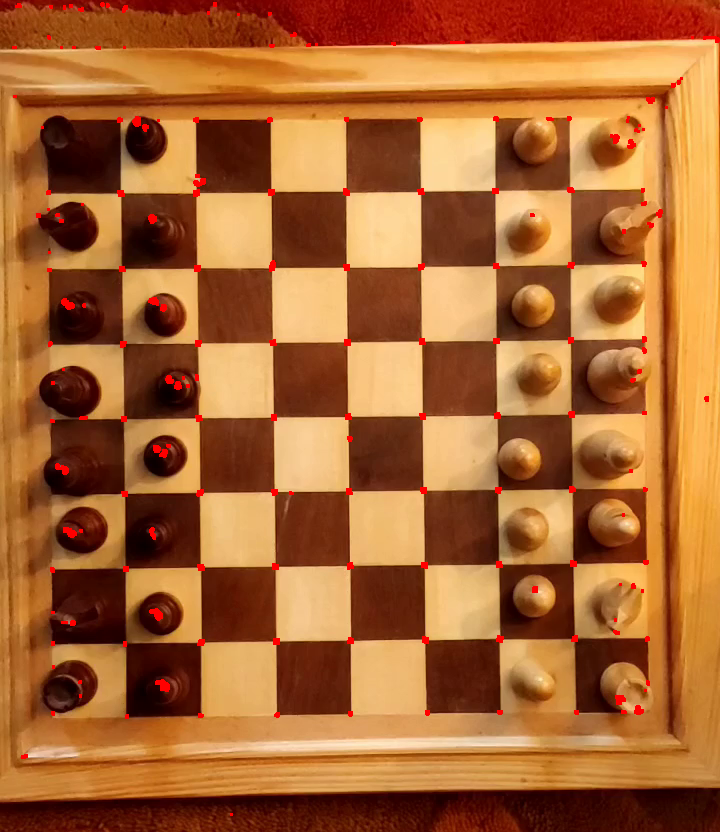

In [194]:
img_blocks = frame.copy()
img_blocks_gray = cv2.cvtColor(img_blocks, cv2.COLOR_BGR2GRAY)
img_blocks_gray = img_blocks_gray.astype(np.float32)

dst = cv2.cornerHarris(img_blocks_gray, 3, 3, 0.04)
# result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)

# Threshold for an optimal value, it may vary depending on the image.
img_blocks[dst > 0.01 * dst.max()] = [0, 0, 255]

corner_list = np.array(np.where(dst > 0.01 * dst.max())).T
corner_list = corner_list[:, [1,0]]


filtered_vertices_list = filter_vertices(corner_list, vertices_list)

plt.scatter(filtered_vertices_list[:, 0], filtered_vertices_list[:, 1])
plt.imshow(frame_rgb)
plt.show()
imshow(img_blocks)


C:\Users\Krzysiaczek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


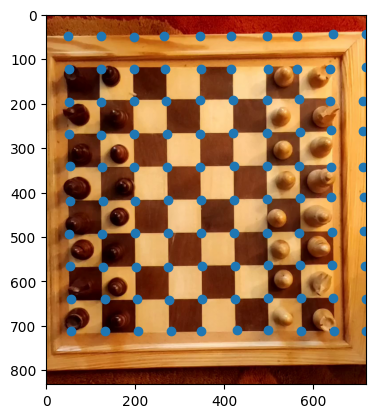

In [196]:

transformations = find_nearest_transformations(filtered_vertices_list)
extended_vertices_list = filtered_vertices_list.copy()
new_list = add_new_vertices(extended_vertices_list, transformations, frame.shape[0], frame.shape[1])

while new_list.shape != extended_vertices_list.shape:
    extended_vertices_list = new_list
    new_list = add_new_vertices(extended_vertices_list, transformations, frame.shape[0], frame.shape[1])


plt.scatter(extended_vertices_list[:, 0], extended_vertices_list[:, 1])
plt.imshow(frame_rgb)
plt.show()

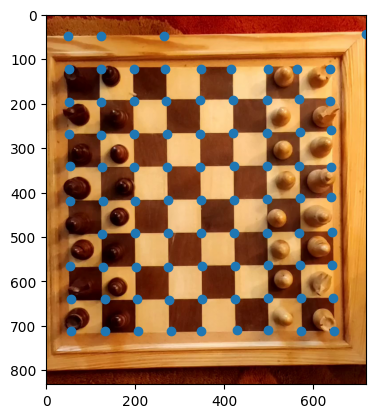

In [197]:
chessboard_corners = filter_vertices(corner_list, extended_vertices_list)

plt.scatter(chessboard_corners[:, 0], chessboard_corners[:, 1])
plt.imshow(frame_rgb)
plt.show()